## Toy optimal control problem in emu-sv

In this notebook we will go through the required steps to set up and solve some optimal control problem.
As an example, we will optimize a pulse sequence to reach a target total magnetization for two interacting atoms. In four steps:
1. Define a parametric sequence
2. Define an `EmulationModel`
3. Define the cost function
4. Run the standard `torch.optim` loop

In [1]:
from pulser import Sequence, Pulse, Register
from pulser.waveforms import BlackmanWaveform, RampWaveform
from pulser.devices import MockDevice

# 1. Parametric sequence
Sequences need to declare the variables/parameters over which we will optimize.

In [2]:
# create register
nqubits = 5
reg = Register.rectangle(1, nqubits, spacing=8, prefix="q")

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# declare sequence variables
omega_param = seq.declare_variable("omega")
area_param = seq.declare_variable("area")

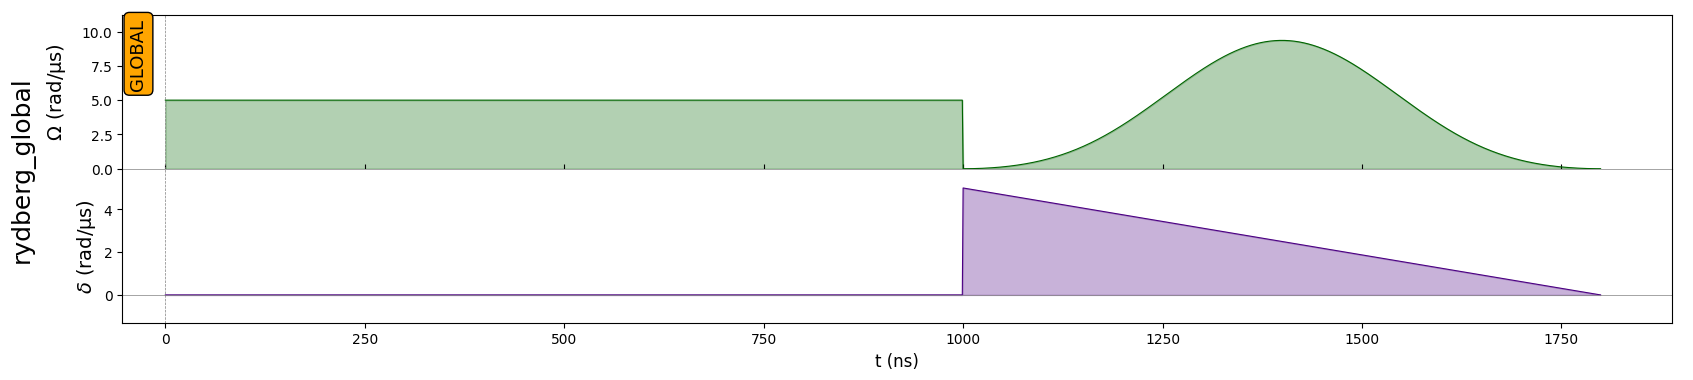

In [3]:
# create pulses
pulse_const = Pulse.ConstantPulse(1000, omega_param, 0.0, 0.0)
amp_wf = BlackmanWaveform(800, area_param)
det_wf = RampWaveform(800, 5.0, 0.0)
pulse_td = Pulse(amp_wf, det_wf, 0)

# add pulses
seq.add(pulse_const, "rydberg_global")
seq.add(pulse_td, "rydberg_global")

# to draw it, the sequence has to be build with concrete variables values
# they don't need to be torch parameters at this stage
seq.build(area=3.14, omega=5.0).draw()

## 2. the `EmulationModel` class
This object is responsible for:
- accept `trainable_parameters` to be optimized and check if they are compatible with `seq.declared_variables`
- update sequences, run them, get results

In [4]:
from emu_sv import SVConfig, Occupation

# final time magnetization
qubit_density = Occupation(evaluation_times=[1], one_state="r")

config = SVConfig(
    dt=20,
    observables=[qubit_density],
    log_level=1000,
    gpu=False
)

In [5]:
import torch
from emu_sv import SVBackend
from emu_sv.emulation_model import EmulationModel

omega = torch.tensor(5.0, requires_grad=True)
area = torch.tensor(torch.pi, requires_grad=True)
trainable_params = {"omega": omega, "area": area}

# create a model to run the sequence with updatable params
bknd = SVBackend(seq, config=config)
model = EmulationModel(seq, bknd, trainable_params)

## 3. loss function
Define the function to be optimized (to zero). It should depend on:
- `Results`
- `target_value`
Ideally, it should be incorporated in `EmulationModel`, however is not entirely clear to me how to do so in a clean way.

In [6]:
from pulser.backend import Results
def loss_fn(res: Results, target_value: torch.Tensor):
    magnetization = res.get_result("occupation", 1.0)
    tot_mag = sum(magnetization).real
    mse = torch.nn.MSELoss()
    return mse(tot_mag, target_value), tot_mag

## 4. Optimization loop
The user needs to input several parameters for running the loop
- `epochs`: number of optimization steps (it can be a max)
- `optimizer`: the `torch.optim` optimization routine. Here stochastic gradient descend.
- `lr`: learning rate for the optimizer. In general each optimizer might come with its own options.
- `target_value`: target value for the loss function

In [7]:
# chose the optimizer, SGD or Adam for example
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

max_epochs = 10
target_value = torch.tensor(1.0, dtype=torch.float64)
tol = 1e-2

for i in range(max_epochs):
    # calculate prediction and loss
    results = model.run()
    loss, expectation = loss_fn(results, target_value)

    model.log_epoch(i, loss, expectation)
    if loss < tol:
        print(f"Optimization converged in {i} steps.")
        break
    
    # backpropagation & reset gradients
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # update sequence with changed pulse parameter values
    model.update()

0) loss: 0.727488
	omega: 5.000	area: 3.142	
Δt = 0.678 s, RSSgpu = 0.000 MB, RSScpu = 660.584 MB, 
1) loss: 0.647277
	omega: 5.087	area: 3.174	
Δt = 0.686 s, RSSgpu = 0.000 MB, RSScpu = 665.864 MB, 
2) loss: 0.588329
	omega: 5.163	area: 3.198	
Δt = 0.671 s, RSSgpu = 0.000 MB, RSScpu = 666.344 MB, 
3) loss: 0.544854
	omega: 5.229	area: 3.216	
Δt = 0.677 s, RSSgpu = 0.000 MB, RSScpu = 666.664 MB, 
4) loss: 0.512241
	omega: 5.287	area: 3.228	
Δt = 0.672 s, RSSgpu = 0.000 MB, RSScpu = 666.664 MB, 
5) loss: 0.487144
	omega: 5.338	area: 3.234	
Δt = 0.668 s, RSSgpu = 0.000 MB, RSScpu = 666.664 MB, 
6) loss: 0.467225
	omega: 5.384	area: 3.236	
Δt = 0.667 s, RSSgpu = 0.000 MB, RSScpu = 666.984 MB, 
7) loss: 0.450876
	omega: 5.425	area: 3.234	
Δt = 0.702 s, RSSgpu = 0.000 MB, RSScpu = 666.984 MB, 
8) loss: 0.436998
	omega: 5.463	area: 3.230	
Δt = 0.679 s, RSSgpu = 0.000 MB, RSScpu = 666.984 MB, 
9) loss: 0.424836
	omega: 5.497	area: 3.223	
Δt = 0.675 s, RSSgpu = 0.000 MB, RSScpu = 666.984 MB, 


A log of the full optimization loop, containing for each epoch
- loss and parameters values
- runtime and memory footprint
can be conveniently stored as dictionary in .json file with the save_log() method

In [8]:
#model.save_log(f"{nqubits}.json")

The final optimized parameters are stored in the model or in the initial parameter dictionary.
Finally, the optimized sequence can be built and drawn again.

omega: 5.529565334320068
area: 3.21323561668396


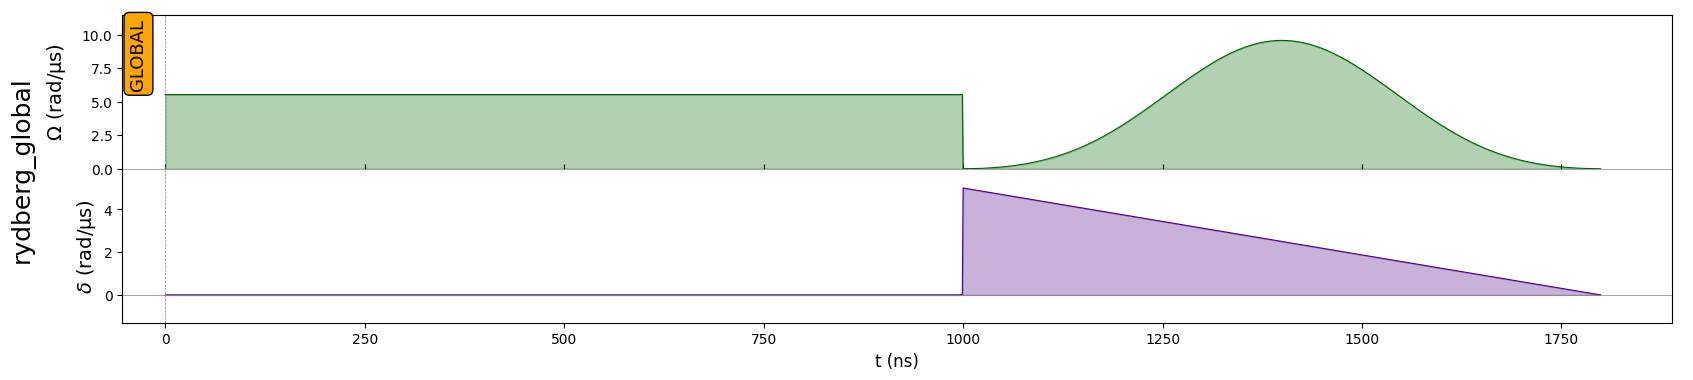

In [9]:
for key, val in trainable_params.items():
    print(f"{key}:", val.item())

seq.build(area=area, omega=omega).draw()